In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle, get_ece
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd
import timeit

### Visualize the data

<AxesSubplot: >

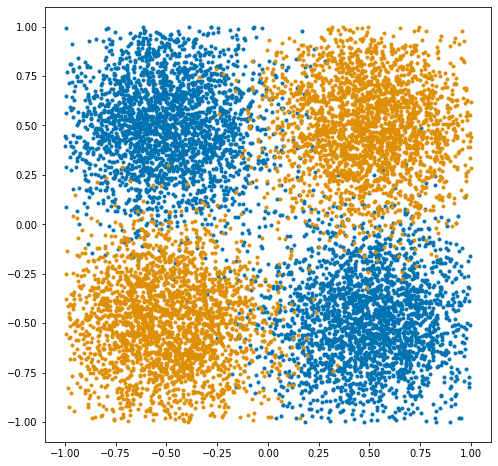

In [2]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [4]:
# network architecture [1000, 1000, 1000, 1000, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Metal device set to: Apple M1 Max


2023-08-31 01:47:06.967794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-31 01:47:06.968074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-08-31 01:47:07.118057: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-31 01:47:07.312954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping


### Calculate posteriors and likelihoods using KDN

In [6]:
df = {}

t_0 = timeit.default_timer()
model_kdn = kdn(network=nn)
model_kdn.fit(X, y, k=2e8)
t_1 = timeit.default_timer()

print(f"Elapsed time: {t_1-t_0} s")

#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod = likelihoods_kdn_geod[:,1].reshape(400,400)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod'] = class1_likelihoods_geod
df['likelihood_class2_geod'] = class2_likelihoods_geod

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Elapsed time: 112.341358584 s
  88/5000 [..............................] - ETA: 8s

2023-08-31 01:49:52.249546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 9s 2ms/step
Calculating distance
Calculating distance


ValueError: Layer "model_1" expects 1 input(s), but it received 1000 input tensors. Inputs received: [<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50319997,  0.25659148])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.19797317,  0.56708868])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.71745833,  0.73094888])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31775017,  0.36260533])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38435358,  0.79120599])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48724624,  0.04851014])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.17882322,  0.37325892])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46812901,  0.62970463])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46703123,  0.2792587 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82267187,  0.67839945])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.17816759,  0.29684801])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55327421,  0.2795174 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42077579,  0.56377148])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58683612,  0.60422277])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58809669,  0.33991153])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59677448,  0.66612063])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.1787866 ,  0.34255005])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65098822,  0.49847347])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41388345,  0.01872428])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69529631,  0.59507251])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64568297,  0.67546786])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5465179 ,  0.55440698])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62027091,  0.89070118])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30810415,  0.88762685])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.36879113,  0.26825244])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.188651  ,  0.36126001])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41283253,  0.21685134])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38712126,  0.46516901])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.9988023 ,  0.44620749])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31017885,  0.50464614])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57469021,  0.46312674])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31721405,  0.36896777])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56889403,  0.79143722])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.68368668,  0.55131368])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66236889,  0.23124421])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.24415197,  0.99458542])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.04571924, 0.48881626])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56813768,  0.51793256])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65813814,  0.69979553])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35482243,  0.54562626])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6811486 ,  0.64170463])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5368132 ,  0.55761328])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.05167091, 0.60760297])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82699183,  0.17444721])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32723436,  0.46675943])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51793442,  0.71946619])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.80223658,  0.4245763 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62050874,  0.92388936])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52648872,  0.08657905])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.06243386, 0.37496347])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51514831,  0.49562243])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63132658,  0.70544606])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64015106,  0.56493745])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.10373743,  0.58491697])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37141583,  0.66827073])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43160258,  0.69478192])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.60087386,  0.55668511])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32336968,  0.31602889])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21254104,  0.51863339])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.39967545,  0.46921692])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26782578,  0.19565917])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44023278,  0.55058882])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46493365,  0.33074109])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.04127774,  0.42203068])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.89775816,  0.22360651])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58650672,  0.83374433])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43135218,  0.30612188])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.03421257, 0.75343497])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.16171754,  0.40477195])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4664606,  0.5013301])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58953899,  0.85580433])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.80308591,  0.46417253])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.15618272,  0.94771147])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21926281,  0.78555688])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6151056 ,  0.38534619])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61185258,  0.57882968])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56780433,  0.27287177])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.18525794,  0.25015979])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82578759,  0.3515765 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63020746,  0.64345175])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.17730192,  0.3180804 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41281017,  0.76318207])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52747104,  0.65236862])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45614349,  0.81461558])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48330087,  0.31243978])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.10852569,  0.29450371])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53874035,  0.20968909])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72019691,  0.46759432])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5727005 ,  0.25082641])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55056094,  0.97235788])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50558093,  0.94151527])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73390069,  0.39243446])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.60969062,  0.37922931])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.15810699,  0.64070591])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.27464725,  0.39363635])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4206699 ,  0.19908598])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37314483,  0.68164078])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33165285,  0.7124403 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34531259,  0.61752953])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.71315679,  0.87216826])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.25309714,  0.42525438])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61458364,  0.92721106])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30006437,  0.36868038])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.39150714,  0.7356792 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.19898386,  0.37467333])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.20672743,  0.32879413])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56699369,  0.74799475])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42131178,  0.12459281])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42494799,  0.7854143 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63231584,  0.79647368])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30479468,  0.55673243])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69105314,  0.49959551])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.75831856,  0.51908528])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.91309823,  0.55006889])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.14942262,  0.98948265])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62696429,  0.27582952])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.88103808,  0.62758274])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53981732,  0.58126961])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.80777321,  0.74934651])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.97723509,  0.71604062])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.07016875, 0.80804946])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52892233,  0.08813398])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44465707,  0.6506049 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.15324204,  0.35371105])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55588706,  0.39736119])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50231233,  0.2343926 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.08373755,  0.56006652])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.85265475,  0.29964772])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.90244286,  0.82087753])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50816744,  0.48116559])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32377416,  0.22808643])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58353217,  0.74587729])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30231952,  0.46783102])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74083309,  0.66883923])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78491743,  0.44586803])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38917677,  0.68168747])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.1797793 , 0.10963301])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63414519,  0.42311783])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.20837805,  0.52396089])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34305358,  0.69292211])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.25771197,  0.39002891])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45274027,  0.66679269])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43365657,  0.7029156 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.88670888,  0.36914398])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29200448,  0.40037969])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.2518609 ,  0.52451874])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59951429,  0.78141256])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38412615,  0.3406993 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5779127 ,  0.84558624])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42068563,  0.70628936])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.19479771,  0.16886472])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.39423823,  0.58407428])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.71876706,  0.24103159])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.20519655,  0.64869129])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.22437882,  0.52488183])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6235385 ,  0.33203987])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.07166421,  0.53024758])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46592145,  0.41322075])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69480446,  0.63922927])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.13922046,  0.67324455])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6787376 ,  0.60568418])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66050422,  0.34259888])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.583793  ,  0.55039902])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52859989,  0.89866412])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61300477,  0.94110954])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64131883,  0.1441597 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.25664936,  0.4391256 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44427675,  0.28474409])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.04570505, -0.01410775])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44740835,  0.33193348])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21371367,  0.50374934])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70624191,  0.27263983])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33270937,  0.67336159])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70260678,  0.34399259])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50481231,  0.75222648])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.49428617,  0.28244946])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74372402,  0.44079628])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31979718,  0.43958551])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51995837,  0.75110974])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.17451097,  0.42494481])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.77203472,  0.28848545])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50424407,  0.50156349])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41111257,  0.31243084])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.09801978, 0.79366015])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.86316333,  0.435091  ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43740299, -0.1315347 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57210087,  0.02931248])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.18816365,  0.37923039])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35234877,  0.80208176])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61451499,  0.30340971])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64250551,  0.50453812])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34139837,  0.66856404])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51330322,  0.52732432])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29867693,  0.3452293 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.02918544, 0.34682577])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79993025,  0.22058972])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21684362,  0.13522644])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70593948,  0.20074451])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.213769  ,  0.44084441])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38361084,  0.15147563])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.19529381,  0.82851931])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.60570647,  0.22245083])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62149732,  0.34135936])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.07897506,  0.62630286])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50020253,  0.74245312])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29745407,  0.69973188])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41678454,  0.48131361])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51831797,  0.66207983])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66373181,  0.63743603])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40196637,  0.21374014])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63371012,  0.49406813])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.2173703 ,  0.61499683])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.68570296,  0.47340356])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46733324,  0.5393866 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79068566,  0.5225531 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.1988126 ,  0.22524236])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45013657,  0.93672408])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70208571,  0.43609165])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70484456,  0.78905188])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67213367, -0.15008373])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.7087601 ,  0.56858493])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42179962,  0.51988684])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.76659255,  0.55709362])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34687586, -0.06237838])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.02987811,  0.484062  ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59077472,  0.92974307])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69845221,  0.45849791])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.25980546,  0.61250968])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31188867,  0.41956659])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73394143,  0.39365636])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21702525,  0.12127716])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.36759429,  0.36730816])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.7472021 ,  0.41834652])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.06752316, 0.47831185])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26509768,  0.35626063])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43719507,  0.76777012])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74127261,  0.39930863])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53101989,  0.45295272])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33686337,  0.11543714])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.84407339,  0.65222657])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.76643496,  0.6277145 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45426342,  0.6596561 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.49876432,  0.46989001])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29515974,  0.58664884])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69093328,  0.69879994])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48567688,  0.91359552])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70260924,  0.529918  ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72922851,  0.71259061])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65652791,  0.49516927])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.97111819,  0.27682189])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6960691,  0.2883232])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.98921128,  0.77263456])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40179868,  0.50277634])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6911214 ,  0.11909236])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64556376,  0.39507571])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.71461053,  0.45382826])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79697959,  0.36957162])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47271233,  0.86331303])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.13449069,  0.64360097])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.9634996 ,  0.64175594])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.97694758,  0.8088028 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52898342,  0.33416593])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.1414003 ,  0.36954579])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4983596,  0.3903533])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52090875,  0.64237183])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47270991,  0.50419742])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43280966,  0.54562227])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59689172,  0.52545443])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26544669,  0.24548467])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45942048,  0.41627561])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3958699 ,  0.71194221])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63847151,  0.58551544])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6423509 ,  0.66483638])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82671661,  0.48586725])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.27249155,  0.27894381])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70515807,  0.4235293 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61776861, -0.11012773])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62041515,  0.37045336])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37487168,  0.79333446])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82296068,  0.51094073])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40007002,  0.66458424])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45691602,  0.62382064])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57734298,  0.43114619])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21667685,  0.67165435])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47460896,  0.44408333])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.1122272 ,  0.80328837])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.95538201,  0.67505278])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.80812549,  0.65737057])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43983665,  0.33488164])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38641685,  0.39320404])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78970447,  0.99239415])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50935134,  0.80156332])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78121377,  0.87714449])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41291684,  0.92185955])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29592337,  0.38344139])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48251981,  0.01355363])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.01006784,  0.35507863])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45645908,  0.35286305])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.71149495,  0.63742598])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72050103,  0.50086977])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.71922923,  0.21649564])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56756877,  0.17692337])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32790044,  0.77615558])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.83333985,  0.54584185])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.8967229 ,  0.17123873])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.347386  ,  0.56308045])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.75639684,  0.55342172])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3610413 ,  0.51601081])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23557218,  0.59437698])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.93318695,  0.72714697])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45879735,  0.48916131])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.698341  ,  0.10790814])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.75003238,  0.59391118])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55332992,  0.28613052])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41979572,  0.62204375])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.2255837 ,  0.36296176])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.0405447,  0.5462014])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62936534,  0.46836843])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44130477,  0.64065003])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30029496,  0.00233248])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74881498,  0.27562515])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53487984,  0.61805151])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.27365172,  0.22782611])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.22929362,  0.42031347])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66273236,  0.9430691 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55525741,  0.42383973])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66019835,  0.79012521])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30960116,  0.4468516 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42422103,  0.55190922])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.24083333,  0.85397752])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50715398,  0.45666181])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.80483117,  0.2772067 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.09754136,  0.67838899])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64824615,  0.22276476])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4751613 ,  0.88114568])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40680222,  0.18050971])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45985847,  0.46580982])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56307957,  0.64929253])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65270721,  0.66203605])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.25384202,  0.35051795])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70288311,  0.60982996])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4377444 ,  0.33438684])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.07304806, 0.58746248])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.12054115,  0.33671898])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.17560944, 0.65696913])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37614815,  0.36411937])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57101509,  0.60300755])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72218425,  0.2808396 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61185297,  0.41798352])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.81637721,  0.65746112])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.71665528,  0.74368097])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.28762894,  0.459452  ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.68171639,  0.42999119])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.28620688,  0.67960339])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55449808,  0.47948866])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4608942 ,  0.80526105])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35878236,  0.70808515])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3725145,  0.6554263])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34617325,  0.61068361])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.60210206,  0.51699223])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45924094,  0.41851544])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48825908,  0.03660729])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.16440436,  0.69102994])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.76772005,  0.57968534])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62731195, -0.02467342])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40169197,  0.07217698])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.87528983,  0.30585118])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59830231,  0.86769047])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31468608,  0.33466443])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.36382181,  0.54507452])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48823809,  0.48708791])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.68820288,  0.76740668])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45883391,  0.5390197 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.16204669, 0.51647825])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23716978,  0.53600022])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.12456052,  0.06216516])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.06821734, 0.71241555])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.99504575,  0.08937794])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.94074069,  0.06607405])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21963732,  0.8828693 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.86532376, -0.14533359])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67632811,  0.28071552])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.75611736,  0.27027705])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.49755271,  0.62132173])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6836436 ,  0.72710986])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47990652,  0.29718405])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.77787867,  0.5421565 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.17346942,  0.81198795])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21066908, -0.00602747])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55673498,  0.67080091])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65917007,  0.40169739])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59591448, -0.05487356])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41022035,  0.46637106])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40884163,  0.79131109])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.83876777,  0.52976759])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43375901,  0.55298367])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3642685 ,  0.13211173])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.60492027,  0.43120301])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56656961,  0.46324496])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73445923,  0.67022113])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45121042,  0.48336338])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23057131,  0.33643767])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43673491,  0.7245529 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.1605944 ,  0.34714061])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64419239,  0.66993278])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5985353 ,  0.94043834])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.09725919,  0.59688478])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57806615,  0.76813353])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.16177822,  0.49299013])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40923077,  0.92284128])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82252915,  0.40434091])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.87591426,  0.18176081])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21926309,  0.35057749])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.00370691, 0.63150829])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.99518713,  0.64817004])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55458903,  0.71072273])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23927532,  0.34090132])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37161054,  0.52748212])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.81258819,  0.43606944])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.20475814, 0.79982718])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42945399,  0.66591735])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57359822,  0.13560609])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26576623,  0.59421605])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32531112,  0.62522094])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47799282,  0.93744814])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4905352 ,  0.38066852])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57869116,  0.36007117])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.2116197 ,  0.72907819])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.7079559 , -0.08780165])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52887049,  0.72094453])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.20418794,  0.75671748])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3670533 ,  0.70408892])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.39694668,  0.77419407])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54817814,  0.67457107])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66275393,  0.69344102])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.85832594,  0.57134421])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.19429935,  0.88745428])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.68455352,  0.30638884])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.28764075,  0.21482013])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59319316,  0.22640086])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50312111,  0.18459151])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57962004,  0.28556909])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.2556629,  0.4628371])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.13454604,  0.56932129])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.76050748,  0.76427864])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59720637,  0.80238163])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65515194,  0.65485216])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.16798818, 0.97928183])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.07082002,  0.66301469])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.89851004,  0.2302875 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.60751875,  0.46349574])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.286513  ,  0.57706916])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73248703,  0.43220734])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.15497518,  0.86140662])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.19003628,  0.67973233])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.2859589 ,  0.33208449])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.11242305,  0.18876876])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46655356,  0.45358465])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.02165494,  0.31316918])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.06300526, 0.19675375])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46214865,  0.49284206])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79760195,  0.49635889])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50846797,  0.49565537])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50006368,  0.29427102])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31887347,  0.51097746])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61662898,  0.67512601])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5794679 ,  0.48724774])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34593891,  0.26269574])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.8148101 ,  0.43164655])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54525579,  0.0473091 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70191635,  0.22797457])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.89257648,  0.08771495])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52328522,  0.81420816])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70665543,  0.61530009])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74014503,  0.52326802])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.08629205,  0.41368021])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.90241662,  0.74980888])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55587741,  0.61420936])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.28254456,  0.17250745])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.60538081,  0.3415635 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26538505,  0.63159967])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5213216 ,  0.77717187])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57481737,  0.35394731])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.80800533,  0.58011892])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6378012 ,  0.92571227])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63384708, -0.02750045])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.27365372,  0.19362968])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53432138,  0.13722284])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.1887984 ,  0.48554866])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.654687 ,  0.3736837])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52924119,  0.52190431])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43995017,  0.86606088])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.07949563,  0.21358083])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40600261,  0.66720194])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50597524,  0.45858992])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.13139831,  0.57712675])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3236528 ,  0.81330225])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54742654,  0.6686441 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56755575,  0.38081288])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63256541,  0.61800002])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56474901,  0.88716931])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58817749,  0.80888619])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29914449, -0.35090557])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.16478326,  0.29102553])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30859209,  0.18495775])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4878291 ,  0.49248102])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63075434,  0.57466082])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41398852,  0.51964114])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29501013,  0.77881597])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.20289966,  0.79773385])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.20070739,  0.31512223])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.93237196,  0.52342011])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38001416,  0.71689038])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26961185,  0.54225433])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33571383,  0.50631018])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.18519691,  0.58478695])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45833233,  0.37102787])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.03164113, 0.81380089])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4230809 ,  0.88532817])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52885628,  0.55457301])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29532211,  0.49322832])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.76279346,  0.6846449 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.36320953,  0.91849835])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26980377,  0.65970637])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30838295,  0.76629689])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58289275,  0.74664116])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32159386,  0.38677675])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43544031,  0.24564892])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.18401265,  0.49603538])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57613654,  0.37898099])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58954658,  0.88655837])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61517678,  0.73094423])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.1883536 , 0.55906099])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67637048,  0.62908757])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26005205,  0.44510102])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29964101,  0.41235438])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43727806,  0.43774584])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59726727,  0.31497969])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3956639 ,  0.93501126])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.94692419,  0.41510678])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69529485,  0.45937413])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.13538741,  0.45844686])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73445718,  0.35081598])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.12409598,  0.44424594])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70567559,  0.54851666])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5849514 ,  0.71177797])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65042106,  0.12255446])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69845292,  0.44302492])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3472904 ,  0.72461429])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.93859978,  0.32045598])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.83293858,  0.59732182])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78583107,  0.57156839])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.19982189,  0.00600123])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26976628,  0.39243283])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42450466,  0.49855867])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.27842978,  0.64285307])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46513761,  0.44123306])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.20132085,  0.29786534])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37435436,  0.33993451])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42917534,  0.51256382])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48389341,  0.69513154])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37330732,  0.52120504])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.13935464,  0.66897637])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55400655,  0.85415777])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51716227,  0.29871793])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.36892467,  0.89790143])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62430879,  0.51408794])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82750916,  0.34817216])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43879335,  0.96281117])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.89655594,  0.05064029])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54838136,  0.54345588])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59688108,  0.27329028])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.39371788,  0.19477837])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66459608,  0.46412898])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57031518,  0.59090812])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.12307262,  0.66482181])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62275476,  0.02890221])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48879804,  0.48132845])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55188959,  0.63110053])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.28522495,  0.7357872 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.18605813, -0.2365793 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.81861612,  0.71507025])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42017954,  0.73335377])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45687438,  0.6459299 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.68779517,  0.26589987])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30837399,  0.70012957])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.1698532 ,  0.76184067])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.87372252,  0.25255183])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.30185228,  0.10928898])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31257619,  0.27498039])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51131391,  0.83799727])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65065363,  0.31653991])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48248812,  0.46677576])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40408678,  0.51240097])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55088641,  0.46818623])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34622179,  0.42291718])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63369616,  0.83972909])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53494814,  0.7491302 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32699171,  0.08154352])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50990552,  0.89987137])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73811661,  0.08867368])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.75331912,  0.48794167])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.10468092,  0.52319101])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.81061937,  0.12530529])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38964254,  0.55723129])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.22103195,  0.66898198])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67843242,  0.82591405])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.16384347,  0.88183738])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48388096,  0.44362583])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.09733673,  0.24865716])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33075085,  0.05755262])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.27898974,  0.38217344])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72071437, -0.02988831])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.76466864,  0.54389236])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.9613013,  0.1773247])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54662658,  0.52264342])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48528653,  0.46235214])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.89504409,  0.3180993 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34797235,  0.5397793 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23564125,  0.58583815])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.19614215,  0.50476823])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54506117,  0.5328087 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41615734,  0.25560196])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35221715,  0.60031822])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65484073,  0.37528384])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55159619,  0.22516005])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.28203313, 0.82811457])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62015718,  0.48382633])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.49257775,  0.15727836])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37627548,  0.12560436])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.1376935 ,  0.55661195])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.01649925,  0.45742148])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.75255701,  0.9745016 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.1490388 ,  0.68564817])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33442459,  0.85536766])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50797406,  0.5545755 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40533831,  0.82081825])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35966985,  0.31964003])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70027814,  0.71015179])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.010222  ,  0.68691056])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29966107,  0.65681057])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23994918,  0.38374451])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.14871659,  0.48763694])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.95804344,  0.54264298])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45350803,  0.93123739])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3328802 ,  0.49908922])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23008609,  0.55521514])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.28465589,  0.33983439])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.96796927,  0.59186386])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56153712,  0.13875604])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55309656,  0.4164829 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34155449,  0.62141004])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.197222  ,  0.44746103])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63219493,  0.48423001])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.39622337,  0.2003308 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32658479,  0.79981121])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41269822,  0.22393035])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.04971394,  0.31105953])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52647965,  0.27647198])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42978202,  0.60519062])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54670211,  0.07111193])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42343878,  0.58353469])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31293725,  0.7545869 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45613217,  0.37326083])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.71270384,  0.79803171])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.519177  ,  0.69946478])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.03793679, 0.74395639])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.77155165,  0.88239182])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.03004018,  0.71614981])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.15322916,  0.82704858])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61251713,  0.28960293])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66434093,  0.51595487])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79897636,  0.89792961])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40106544,  0.74972111])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82816767,  0.44587572])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45732801,  0.42639738])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.91674751,  0.33273072])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.25553984,  0.22032644])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58922153,  0.22944599])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.14599175, 0.26759423])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.17137284,  0.44411716])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61410467,  0.7625803 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65326356,  0.17649703])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47326163,  0.36420701])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52661264,  0.44137338])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51901324,  0.42520811])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73278298,  0.6127539 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.12397339,  0.4180472 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34950967,  0.7772184 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44576253,  0.68837066])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56675898,  0.11926997])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35728153,  0.26318736])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50496071,  0.63178155])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63892501,  0.3255667 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.49934501,  0.70776151])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72802774,  0.5839768 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32849344,  0.52434488])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3532954 ,  0.54093903])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.16386114,  0.45927081])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64808575,  0.62685218])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.27737045,  0.21382479])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58878064,  0.61868288])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50051   ,  0.72495512])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34264621,  0.17150024])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.93965094,  0.50406368])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64470732,  0.49881488])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57709202,  0.59397888])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.90171546,  0.6273727 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.15518633,  0.40804118])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5855026 ,  0.89016348])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67239546,  0.23750747])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37727848,  0.64268786])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43296714,  0.41695915])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33512681,  0.72256683])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72136199,  0.54963171])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.16011935, 0.33380589])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.93280583,  0.00202351])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82201983,  0.63996497])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40680864,  0.3535457 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82215859,  0.70383847])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53147416,  0.65269397])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58234574,  0.47211244])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78146062, -0.0099722 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.25623847,  0.79059305])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33842859,  0.56943818])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.449321  ,  0.45499645])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72640726,  0.82914897])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.7859386 ,  0.37789611])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35993596,  0.30173452])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70789915,  0.43032224])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57086979,  0.76480647])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52307079,  0.3726662 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78586674,  0.80463557])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79742419,  0.66681257])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70610252,  0.74408693])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61433769,  0.54805029])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79665949,  0.3959185 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.60642027,  0.53863098])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79695371,  0.1738486 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.28046026,  0.70569972])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55494641,  0.49384265])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.0087856 , 0.63344379])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38110299,  0.59878145])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62944086,  0.349691  ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.87255663,  0.53564362])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67260965,  0.33791625])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59526174,  0.16523947])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42280313,  0.52334123])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.68078128,  0.38986923])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37137415,  0.37317657])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69587079,  0.69627958])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46008471, -0.19548993])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31018052,  0.52448512])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44200839,  0.3937521 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.17597341,  0.63696043])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50545966,  0.3819931 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57579498,  0.26004598])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.88614588,  0.57083541])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.80044455,  0.30173337])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44593381,  0.59168671])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44150159,  0.77042168])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.92552886,  0.43943617])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6477526 ,  0.49333507])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23646979,  0.72787254])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.85065155,  0.55712048])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.14978101,  0.89093557])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65099575,  0.86977419])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.18049558,  0.40638078])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53031319,  0.56317525])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63255825,  0.32793875])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.10532433,  0.45201233])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45622818,  0.8607858 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57797384,  0.52566251])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.93398409,  0.84313281])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38820915,  0.85672791])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.80921599,  0.38655194])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73607015,  0.09001047])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42463086,  0.33923485])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54588106,  0.86746849])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42928535, -0.09167324])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40615643,  0.54358026])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.18827161,  0.51337635])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.09801359,  0.36010831])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66900034,  0.2983895 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47355966,  0.60645177])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59012389,  0.71721629])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79166756,  0.61008154])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.11854012, -0.09183115])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66250551,  0.36529471])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.81133878,  0.33325599])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41608647,  0.49308749])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52520037,  0.69543359])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56339793,  0.47780899])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63681401,  0.39337293])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.18501003, 0.74866637])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44702058,  0.74039924])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35258249,  0.06135597])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26881629,  0.72923687])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41798875,  0.63525935])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.39765243,  0.53431491])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.94385499,  0.28934453])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.09007473,  0.06687146])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69514075,  0.67776207])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67883362,  0.59610476])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38513641,  0.65893987])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.81000087,  0.73505388])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52753386,  0.81680794])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4214935 ,  0.90750353])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.27177676,  0.62399848])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.14014038,  0.10117057])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.19877151,  0.47272791])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59610466,  0.53836193])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38839888,  0.43240001])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62427783,  0.54930684])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.75473124,  0.65588368])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46247224,  0.55325949])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.57798762,  0.31570733])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.32131159,  0.65117879])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.60032297,  0.76883423])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47715312,  0.6602703 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.05338674,  0.48149066])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53032983,  0.54974824])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.43458631,  0.77774507])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51655819,  0.67272908])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67344748,  0.57643575])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58219408,  0.95669711])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.92906772,  0.34453287])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.83924652,  0.38651854])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33294664,  0.40441719])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.77810106,  0.3638705 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5753012 ,  0.58777918])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51203027,  0.57587423])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64374092,  0.45842002])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48323663,  0.53522852])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42755562,  0.60598954])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.27512393,  0.6411357 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.36354122,  0.6737018 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.88483165,  0.65808743])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.62610331,  0.25136778])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44985964,  0.75286691])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29573519,  0.73800973])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79915405,  0.4527784 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69047591,  0.73117049])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.71724175,  0.49395737])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53305304,  0.30807137])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46583766,  0.58179613])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.49721994,  0.56037635])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.12245511,  0.76053569])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.69208341,  0.79076636])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.01058484,  0.57627982])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64176208,  0.91356741])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35930213,  0.93584325])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37641825,  0.49208413])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29991574,  0.58041821])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56704904,  0.78454973])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5451027 ,  0.37047008])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4533885 ,  0.51725965])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21967665,  0.57693051])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.7941564 ,  0.20914908])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.06869099,  0.28538805])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23930757,  0.38787423])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.70953843,  0.35361032])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72663027,  0.19938362])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34870756,  0.28741494])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.26805199,  0.40786653])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37436414,  0.32795324])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44970501,  0.67951896])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.12346796,  0.88485197])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.07964926,  0.73650509])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67990455,  0.52763334])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.44357649,  0.11537693])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53066246,  0.4900661 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73154237,  0.57215001])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74198333,  0.25777566])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.12096602,  0.34240673])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.73941165,  0.72716684])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.77116301,  0.09342955])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54930289,  0.24608562])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.20957089,  0.23822422])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61294907,  0.44655504])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55068435,  0.52836804])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55722834,  0.59550121])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.10633096,  0.46082353])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.76167903,  0.52164569])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.20763386,  0.54822898])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65977133,  0.08068776])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56512149,  0.5445369 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.31291482,  0.38450083])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.82935332,  0.00187565])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.03383626,  0.28349196])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78679548,  0.37040138])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.48049894,  0.46834503])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.52249437,  0.49306934])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65893882,  0.6160887 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45150617,  0.41800358])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42206263,  0.27261168])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58111676,  0.3996371 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5053784,  0.4310241])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42105902,  0.34507898])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.18839731,  0.60885713])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.45975904,  0.44922383])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51517938,  0.48245127])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.55645462,  0.51271776])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59742876,  0.65989451])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.2220645 ,  0.41314936])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42938475,  0.66815131])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47596856,  0.59642903])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.8567426 ,  0.46067823])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.11581766,  0.31425933])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74718933,  0.37738928])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.39156974,  0.46236642])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61414086,  0.53436839])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61969572,  0.40972617])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.90698887,  0.10728055])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47084078,  0.35286245])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74273909,  0.72035329])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64184555,  0.47276113])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42685138,  0.11197252])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38707448,  0.61356247])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.59019141,  0.91249407])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.08399854,  0.49987999])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65359596,  0.95318864])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.17104785,  0.51852922])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.92852219,  0.79367593])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.07338421,  0.99528722])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56158635,  0.36242555])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.76294073,  0.58872465])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.75270849,  0.79171828])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.36872973,  0.90123803])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74120418,  0.06814633])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.36819716,  0.72208524])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.85186075,  0.67427101])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.81744755,  0.52871897])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.51017371,  0.82830922])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53579696,  0.54330955])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.87690395,  0.17043201])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40265057,  0.63864712])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46880529, -0.27638072])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6440371 ,  0.41036073])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41796975,  0.14692007])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.81683205,  0.20973661])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5082501 ,  0.52118574])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.56973271,  0.11139377])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.35014125,  0.44965513])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63912454, -0.18248067])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50946835,  0.18839075])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.5062342 ,  0.65320124])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.24658611,  0.42585339])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.38883406,  0.99860757])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.80438448,  0.59805641])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.22833806,  0.45162553])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.23091072,  0.76094301])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.85293597,  0.48349204])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21624019,  0.74228692])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53949185,  0.41799484])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.99425179,  0.43566339])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66696015,  0.64375584])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42510499,  0.6718379 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.37026988,  0.22635368])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.21233166,  0.52747111])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.81841089,  0.60706236])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.49236751,  0.29925003])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.50932783,  0.79655023])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.11315831,  0.23221432])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.61987334,  0.40042835])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58774012,  0.86952412])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.4763509,  0.7722976])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65934759,  0.7705419 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.76935869,  0.55606281])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.24993895,  0.72460985])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40254491,  0.85193559])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78037089,  0.66690397])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.09768737,  0.53999587])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.6127473 ,  0.96569948])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.46379018,  0.39400582])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78567551,  0.53816433])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.74479167,  0.59893819])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.79345062,  0.21299489])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.78986201,  0.2886049 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.49392277,  0.60701938])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47900139,  0.71965504])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.54702524,  0.45472549])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.85882737,  0.46003766])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.3407144 ,  0.60878674])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.67562237,  0.54776975])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.49036753,  0.64136279])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42685017,  0.64902395])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.36816653,  0.41539823])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.53731308,  0.3018272 ])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34379708,  0.48862723])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66932354,  0.63593698])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40908999,  0.29545296])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.64791783,  0.09521739])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.41679702,  0.66826024])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.19973758, 0.54495897])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40045489,  0.55926242])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.72647967,  0.33953885])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.14372464, 0.23759251])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.29508646,  0.81925268])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.58879843,  0.72822164])>]

In [ ]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[100:300, 100:300] = 1 - tmp
#df["true_proba"] = proba_true

In [ ]:
fig1, ax = plt.subplots(1, 4, figsize=(30, 150))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    1-posterior_rf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("RF Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    1-posterior_kdf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDF-Euclidean Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    1-posterior_kdf_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDF-Geodesic Class Posteriors", fontsize=24)
ax[3].set_aspect("equal")
plt.show()

### Visualize class likelihoods

In [ ]:
fig1, ax = plt.subplots(1, 4, figsize=(32, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods (Euclidean)", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods (Euclidean)", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    class1_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("Class 1 Likelihoods (Geodesic)", fontsize=24)
ax[2].set_aspect("equal")

ax3 = ax[3].imshow(
    class2_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("Class 2 Likelihoods (Geodesic)", fontsize=24)
ax[3].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [ ]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/sinewave_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((true_posterior.ravel(), 1-true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_sinewave(sample)
    X_test, y_test = generate_sinewave(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y, k=1e10)

    error_kdf = 1 - np.mean(model_kdf.predict(X_test)==y_test)
    error_kdf_geod = 1 - np.mean(model_kdf.predict(X_test, distance='Geodesic')==y_test)
    error_rf = 1 - np.mean(model_kdf.rf_model.predict(X_test)==y_test)
    
    proba_kdf = model_kdf.predict_proba(grid_samples)
    proba_kdf_geod = model_kdf.predict_proba(grid_samples, distance='Geodesic')
    proba_rf = model_kdf.rf_model.predict_proba(grid_samples)
    
    hellinger_dis_kdf = hellinger(true_posterior, proba_kdf)
    hellinger_dis_kdf_geod = hellinger(true_posterior, proba_kdf_geod)
    hellinger_dis_rf = hellinger(true_posterior, proba_rf)
    
    
    return error_kdf, error_kdf_geod, error_rf, hellinger_dis_kdf, hellinger_dis_kdf_geod, hellinger_dis_rf

def experiment_out(in_sample, r, n_test):
    X, y = generate_sinewave(in_sample)
    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y, k=1e3)

    X_ood = sample_unifrom_circle(n=n_test, r=r)
    mmcOut_rf = np.mean(np.max(model_kdf.rf_model.predict_proba(X_ood), axis=1))
    mmcOut_kdf = np.mean(np.max(model_kdf.predict_proba(X_ood), axis=1))
    mmcOut_kdf_geod = np.mean(np.max(model_kdf.predict_proba(X_ood, distance='Geodesic'), axis=1))
    mmcOut_tree = np.mean(np.max(model_kdf.rf_model.estimators_[0].predict_proba(X_ood), axis=1))
    
    return mmcOut_kdf, mmcOut_kdf_geod, mmcOut_rf
        
    
error_kdf_med = []
error_kdf_25 = []
error_kdf_75 = []
error_kdf_geod_med = []
error_kdf_geod_25 = []
error_kdf_geod_75 = []
error_rf_med = []
error_rf_25 = []
error_rf_75 = []

hellinger_kdf_med = []
hellinger_kdf_25 = []
hellinger_kdf_75 = []
hellinger_kdf_geod_med = []
hellinger_kdf_geod_25 = []
hellinger_kdf_geod_75 = []
hellinger_rf_med = []
hellinger_rf_25 = []
hellinger_rf_75 = []


mmcOut_kdf_med = []
mmcOut_kdf_25 = []
mmcOut_kdf_75 = []
mmcOut_kdf_geod_med = []
mmcOut_kdf_geod_25 = []
mmcOut_kdf_geod_75 = []
mmcOut_rf_med = []
mmcOut_rf_25 = []
mmcOut_rf_75 = []


#### do out-of-distribution results ####
for r in np.arange(0,10.5,.5):
    mmcOut_kdf = []
    mmcOut_rf = []
    mmcOut_kdf_geod = []
    
    res = Parallel(n_jobs=-1)(
            delayed(experiment_out)(
                    1000,
                    r,
                    n_test
                    ) for _ in range(mc_reps)
                )
    
    for ii in range(mc_reps):
        mmcOut_kdf.append(res[ii][0])
        mmcOut_kdf_geod.append(res[ii][1])
        mmcOut_rf.append(res[ii][2])
        
    
    
    mmcOut_kdf_med.append(
        np.median(mmcOut_kdf)
    )
    mmcOut_kdf_25.append(
        np.quantile(mmcOut_kdf, [0.25])[0]
    )
    mmcOut_kdf_75.append(
        np.quantile(mmcOut_kdf, [0.75])[0]
    )
    
    mmcOut_kdf_geod_med.append(
        np.median(mmcOut_kdf)
    )
    mmcOut_kdf_geod_25.append(
        np.quantile(mmcOut_kdf, [0.25])[0]
    )
    mmcOut_kdf_geod_75.append(
        np.quantile(mmcOut_kdf, [0.75])[0]
    )
    
    mmcOut_rf_med.append(
        np.median(mmcOut_rf)
    )
    mmcOut_rf_25.append(
        np.quantile(mmcOut_rf, [0.25])[0]
    )
    mmcOut_rf_75.append(
        np.quantile(mmcOut_rf, [0.75])[0]
    )
    
        
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdf = []
    err_kdf_geod = []
    err_rf = []
    hellinger_kdf = []
    hellinger_kdf_geod = []
    hellinger_rf = []
    
    for ii in range(mc_reps):
        err_kdf.append(res[ii][0])
        err_kdf_geod.append(res[ii][1])
        err_rf.append(res[ii][2])
        hellinger_kdf.append(res[ii][3])
        hellinger_kdf_geod.append(res[ii][4])
        hellinger_rf.append(res[ii][5])
        

    error_kdf_med.append(
        np.median(err_kdf)
    )
    error_kdf_25.append(
        np.quantile(err_kdf, [0.25])[0]
    )
    error_kdf_75.append(
        np.quantile(err_kdf, [0.75])[0]
    )
    
    error_kdf_geod_med.append(
        np.median(err_kdf)
    )
    error_kdf_geod_25.append(
        np.quantile(err_kdf, [0.25])[0]
    )
    error_kdf_geod_75.append(
        np.quantile(err_kdf, [0.75])[0]
    )
    
    error_rf_med.append(
        np.median(err_rf)
    )
    error_rf_25.append(
        np.quantile(err_rf, [0.25])[0]
    )
    error_rf_75.append(
        np.quantile(err_rf, [0.75])[0]
    )
    
    
    hellinger_kdf_med.append(
        np.median(hellinger_kdf)
    )
    hellinger_kdf_25.append(
        np.quantile(hellinger_kdf, [0.25])[0]
    )
    hellinger_kdf_75.append(
        np.quantile(hellinger_kdf, [0.75])[0]
    )
    
    hellinger_kdf_geod_med.append(
        np.median(hellinger_kdf_geod)
    )
    hellinger_kdf_geod_25.append(
        np.quantile(hellinger_kdf_geod, [0.25])[0]
    )
    hellinger_kdf_geod_75.append(
        np.quantile(hellinger_kdf_geod, [0.75])[0]
    )
    
    hellinger_rf_med.append(
        np.median(hellinger_rf)
    )
    hellinger_rf_25.append(
        np.quantile(hellinger_rf, [0.25])[0]
    )
    hellinger_rf_75.append(
        np.quantile(hellinger_rf, [0.75])[0]
    )
    
    

df['error_kdf_med'] = error_kdf_med
df['error_kdf_25'] = error_kdf_25
df['error_kdf_75'] = error_kdf_75

df['error_kdf_geod_med'] = error_kdf_geod_med
df['error_kdf_geod_25'] = error_kdf_geod_25
df['error_kdf_geod_75'] = error_kdf_geod_75

df['error_rf_med'] = error_rf_med
df['error_rf_25'] = error_rf_25
df['error_rf_75'] = error_rf_75

df['hellinger_kdf_med'] = hellinger_kdf_med
df['hellinger_kdf_25'] = hellinger_kdf_25
df['hellinger_kdf_75'] = hellinger_kdf_75

df['hellinger_kdf_geod_med'] = hellinger_kdf_geod_med
df['hellinger_kdf_geod_25'] = hellinger_kdf_geod_25
df['hellinger_kdf_geod_75'] = hellinger_kdf_geod_75

df['hellinger_rf_med'] = hellinger_rf_med
df['hellinger_rf_25'] = hellinger_rf_25
df['hellinger_rf_75'] = hellinger_rf_75

df['mmcOut_kdf_med'] = mmcOut_kdf_med
df['mmcOut_kdf_25'] = mmcOut_kdf_25
df['mmcOut_kdf_75'] = mmcOut_kdf_75

df['mmcOut_kdf_geod_med'] = mmcOut_kdf_geod_med
df['mmcOut_kdf_geod_25'] = mmcOut_kdf_geod_25
df['mmcOut_kdf_geod_75'] = mmcOut_kdf_geod_75

df['mmcOut_rf_med'] = mmcOut_rf_med
df['mmcOut_rf_25'] = mmcOut_rf_25
df['mmcOut_rf_75'] = mmcOut_rf_75

In [5]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=2e8)
    
    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    
    proba_dn = model_kdn.network.predict(X_test)
    proba_kdn = model_kdn.predict_proba(X_test)
    predicted_label_dn = np.argmax(proba_dn,axis=1)
    predicted_label_kdn = np.argmax(proba_kdn, axis=1)
    error_kdn = 1 - np.mean(predicted_label_kdn==y_test)   
    error_dn = 1 - np.mean(predicted_label_dn==y_test)
    ece_dn = get_ece(proba_dn, predicted_label_dn, y_test)
    ece_kdn = get_ece(proba_kdn, predicted_label_kdn, y_test)
    
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_dn = model_kdn.network.predict(grid_samples)
    hellinger_dis_kdn = hellinger(1-true_posterior, proba_kdn)
    hellinger_dis_dn = hellinger(1-true_posterior, proba_dn)
    mmcIn_dn = np.mean(np.max(proba_dn, axis=1)) 
    mmcIn_kdn = np.mean(np.max(proba_kdn, axis=1))
    
    return error_kdn, error_dn, hellinger_dis_kdn, hellinger_dis_dn, mmcIn_kdn, mmcIn_dn, ece_kdn, ece_dn

def experiment_out(in_sample, r, n_test):
    mmcOut_dn = np.zeros(len(r),dtype=float)
    mmcOut_kdn = np.zeros(len(r),dtype=float)
    
    X, y = generate_gaussian_parity(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e3)
    
    for ii, r_ in enumerate(r):
        X_ood = sample_unifrom_circle(n=n_test, r=r_)
        mmcOut_dn[ii] = np.mean(np.max(
            model_kdn.network.predict(X_ood), axis=1
            )
        )
        mmcOut_kdn[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
    
    return mmcOut_kdn, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []
ece_kdn_med = []
ece_kdn_25 = []
ece_kdn_75 = []
ece_dn_med = []
ece_dn_25 = []
ece_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []

mmcIn_kdn_med = []
mmcIn_kdn_25 = []
mmcIn_kdn_75 = []
mmcIn_dn_med = []
mmcIn_dn_25 = []
mmcIn_dn_75 = []

mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []

#### do out-of-distribution results ####
r = np.arange(0,10.5,.5)
mmcOut_kdn = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_dn = np.zeros((len(r),mc_reps), dtype=float)

for rep in range(mc_reps):
    mmcOut_kdn[:,rep], mmcOut_dn[:,rep] = experiment_out(1000, r, n_test)
    
    
    
mmcOut_kdn_med = np.median(mmcOut_kdn, axis=1)
mmcOut_kdn_25 = np.quantile(mmcOut_kdn, [0.25], axis=1)
mmcOut_kdn_75 = np.quantile(mmcOut_kdn, [0.75], axis=1)
    
mmcOut_dn_med = np.median(mmcOut_dn, axis=1)
mmcOut_dn_25 = np.quantile(mmcOut_dn, [0.25], axis=1)
mmcOut_dn_75 = np.quantile(mmcOut_dn, [0.75], axis=1)
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdn = []
    err_dn = []
    hellinger_kdn = []
    hellinger_dn = []
    mmcIn_kdn = []
    mmcIn_dn = []
    ece_kdn = []
    ece_dn = []
    for ii in range(mc_reps):
        err_kdn.append(res[ii][0])
        err_dn.append(res[ii][1])
        hellinger_kdn.append(res[ii][2])
        hellinger_dn.append(res[ii][3])
        mmcIn_kdn.append(res[ii][4])
        mmcIn_dn.append(res[ii][5])
        ece_kdn.append(res[ii][6])
        ece_dn.append(res[ii][7])

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )

    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    ece_dn_med.append(
        np.median(ece_dn)
    )
    ece_dn_25.append(
        np.quantile(ece_dn, [0.25])[0]
    )
    ece_dn_75.append(
        np.quantile(ece_dn, [0.75])[0]
    )
    
    ece_kdn_med.append(
        np.median(ece_kdn)
    )
    ece_kdn_25.append(
        np.quantile(ece_kdn, [0.25])[0]
    )
    ece_kdn_75.append(
        np.quantile(ece_kdn, [0.75])[0]
    )
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )

    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )

    mmcIn_kdn_med.append(
        np.median(mmcIn_kdn)
    )
    mmcIn_kdn_25.append(
        np.quantile(mmcIn_kdn, [0.25])[0]
    )
    mmcIn_kdn_75.append(
        np.quantile(mmcIn_kdn, [0.75])[0]
    )

    mmcIn_dn_med.append(
        np.median(mmcIn_dn)
    )
    mmcIn_dn_25.append(
        np.quantile(mmcIn_dn, [0.25])[0]
    )
    mmcIn_dn_75.append(
        np.quantile(mmcIn_dn, [0.75])[0]
    )


df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['ece_dn_med'] = ece_dn_med
df['ece_dn_25'] = ece_dn_25
df['ece_dn_75'] = ece_dn_75

df['ece_kdn_med'] = ece_kdn_med
df['ece_kdn_25'] = ece_kdn_25
df['ece_kdn_75'] = ece_kdn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcIn_kdn_med'] = mmcIn_kdn_med
df['mmcIn_kdn_25'] = mmcIn_kdn_25
df['mmcIn_kdn_75'] = mmcIn_kdn_75

df['mmcIn_dn_med'] = mmcIn_dn_med
df['mmcIn_dn_25'] = mmcIn_dn_25
df['mmcIn_dn_75'] = mmcIn_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25.reshape(-1)
df['mmcOut_kdn_75'] = mmcOut_kdn_75.reshape(-1)

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25.reshape(-1)
df['mmcOut_dn_75'] = mmcOut_dn_75.reshape(-1)

Metal device set to: Apple M1 Max


2023-05-14 13:43:52.943362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-14 13:43:52.943514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-14 13:43:53.132680: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-14 13:43:53.261936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-05-14 13:43:55.078574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:43:58.383805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:00.082420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:03.471214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:05.208749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:08.359047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 89: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:09.231151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:12.401459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:14.132742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-05-14 13:44:17.531907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 131: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:18.722510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:21.909301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:23.622300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:26.949169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:28.741363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:32.128744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:33.901018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:37.240119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:44:37.696045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:41.137136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 164: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:43.900888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:47.122623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:47.789561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:50.883093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:54.008207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:57.129748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:00.263289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:03.460120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:04.495623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:07.686347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 153: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:10.229598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:13.363426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-05-14 13:45:16.572411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:19.758233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 115: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:21.758975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:24.826961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 141: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:45:27.273493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:30.356282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 164: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:33.061619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:36.583602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 125: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:44.829643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:48.145315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 100: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:55.067852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:58.385028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 103: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:05.536529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:08.845080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 57: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:13.574024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:16.891770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 113: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:24.526500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:27.853580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:46:31.723376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:35.035539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 70: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:40.455994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:43.796206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:47.643609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:51.020595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:46:56.981549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:00.293214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 101: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:47:07.363071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:10.780622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 124: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:47:29.603506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:33.568281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:47:42.804915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:46.417085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 17: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:47:54.191706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:57.825927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 80: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:48:12.120010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:48:15.776966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:48:27.382973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:48:31.114496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 113: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:48:48.841315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:48:52.494674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 102: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:49:09.024901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:49:12.655246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:49:21.057498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:49:24.736244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:49:37.710290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:49:41.353101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:49:54.439967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:49:58.131963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:52:31.265104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:52:37.259756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:55:09.021998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:55:15.442974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 63: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:57:58.272005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:58:04.425862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 84: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:13:40.590305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:13:47.030442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 75: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:16:34.306023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:16:40.491547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 68: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:19:24.098320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:19:30.305484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:21:53.678449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:21:59.797983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 99: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:24:58.230794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:25:04.524278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:27:43.063286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:27:49.161399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:30:21.613053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:30:27.508915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:40:32.396143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:40:41.548202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:50:41.913234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:50:51.093694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:00:54.040045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:01:03.657211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:11:14.461909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-05-14 15:11:24.387463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 167: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:23:33.458381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:23:42.585471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:33:45.174488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:33:54.292359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:44:04.824045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:44:13.443290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 148: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:55:54.398512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:56:03.228196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 167: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 16:08:02.635974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 16:08:11.463702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 16:18:59.341697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


"df['mmcOut_kdn_med'] = mmcOut_kdn_med\ndf['mmcOut_kdn_25'] = mmcOut_kdn_25.reshape(-1)\ndf['mmcOut_kdn_75'] = mmcOut_kdn_75.reshape(-1)\n\ndf['mmcOut_dn_med'] = mmcOut_dn_med\ndf['mmcOut_dn_25'] = mmcOut_dn_25.reshape(-1)\ndf['mmcOut_dn_75'] = mmcOut_dn_75.reshape(-1)"

### Save the result

In [7]:
import pickle
filename = 'results/gxor.pickle'

with open(filename, 'wb') as f:
    pickle.dump(df,f)

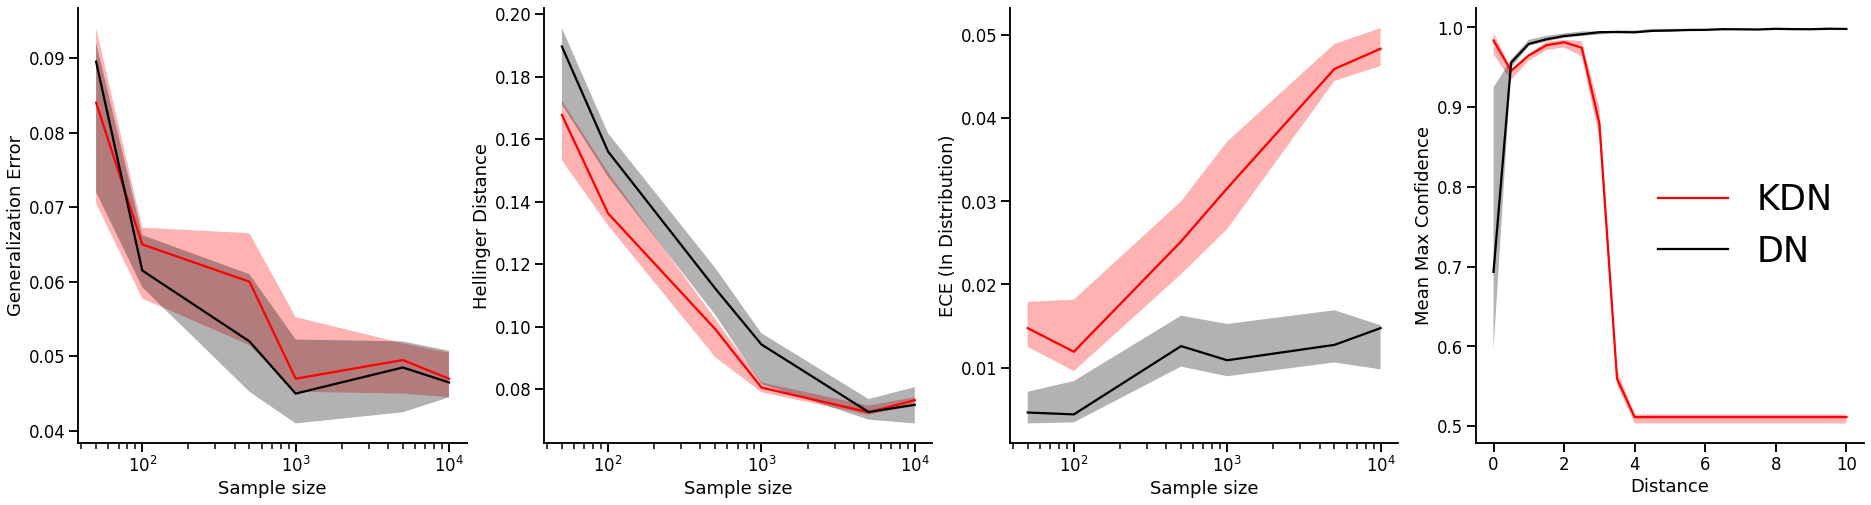

In [6]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['ece_kdn_med'], c="r", label='KDN')
ax[2].plot(sample_size, df['ece_dn_med'], c="k", label='DN')
#ax[2].plot(sample_size, df['mmcIn_tree_med'], c="b", label='DT')

ax[2].fill_between(sample_size, df['ece_kdn_25'], df['ece_kdn_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['ece_dn_25'], df['ece_dn_75'], facecolor='k', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('ECE (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN')
ax[3].plot(r, df['mmcOut_dn_med'], c="k", label='DN')

ax[3].fill_between(r, df['mmcOut_kdn_25'], df['mmcOut_kdn_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df['mmcOut_dn_25'], df['mmcOut_dn_75'], facecolor='k', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [78]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [79]:
sample = 1000
reps = 10
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_dn = []
roc_kdn = []

fpr_dn = []
fpr_kdn = []
reps_list = []

for ii in range(reps):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=1, network=nn)
    model_kdn.fit(X, y)

    dn_in_conf = np.max(model_kdn.network.predict(X_test), axis=1)
    dn_out_conf = np.max(model_kdn.network.predict(X_ood), axis=1)
    dn_conf = np.hstack((dn_in_conf, dn_out_conf))
    roc_dn.append(
        roc_auc_score(true_labels, dn_conf)
    )
    fpr_dn.append(
        fpr_at_95_tpr(dn_in_conf, dn_out_conf)
    )
    
    

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

2023-03-06 09:26:59.365859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 129: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.98it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 09:29:19.360454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:29:19.846879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.01it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 09:31:31.755608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:31:32.253041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:41<00:00,  1.12s/it]


 1/32 [..............................] - ETA: 2s

2023-03-06 09:50:17.663610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:50:18.167306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [23:45<00:00,  1.43s/it]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:14:14.191732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:14:14.710628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.16it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:16:26.411805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:16:26.905171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.83it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:18:41.104489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:18:41.582798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 114: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.93it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:21:01.282403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:21:01.783859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.06it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:23:10.871671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:23:11.402165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.03it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:25:23.137776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:25:23.632406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.84it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:27:35.285419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


In [80]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdn), np.std(roc_kdn)))
print("DN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_dn), np.std(roc_dn)))

KDN AUROC = 0.955 +/- 0.003
DN AUROC = 0.324 +/- 0.074


In [81]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdn), np.std(fpr_kdn)))
print("DN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_dn), np.std(fpr_dn)))

KDN FPR@95 = 0.504 +/- 0.356
DN FPR@95 = 0.910 +/- 0.081
